<div class="alert alert-block alert-info">
<b>There are three validation checks</b> we need to do on each hand combination that was passed into the previous array in order to evaluate if it's a legitimate hand or not: 
</div>

1.  The hand level sum needs to be lower than the max value for the hand and level:
    - This is done by assigning each card in the combination it's level, so a level 1 card gets a 1, level 2 a 2, etc.
    - The sum of the array's level values then needs to be lower than the max value given by the following formula:
        - Max value formula = ((([1] + [Level])*[Level])/2) + ([Hand Size] - [Level])
        - Ex: For the Brute class, when evaluating hand combinations at level 2's selection time:
            - (((1+2)*2)/2) + (10-2)
            - 3 + 8 = 11
        - Intuitively, this makes sense as at level 1, the Brute class would have 10 level 1 cards for a total of 10
        - At level 2, at most, you would select one level 2 card and replace a level 1 card with it
        - That would replace a 1 value with a 2, taking the max value possible up to 11
        - If we ever run into a class that has a hand size lower than 8, this formula will need to be tweaked
            - This is because at a hand size of 8, you could remove a level 1 card for each level up
            - At a hand size of 7 or lower, the top level ups would mean you need to replace a card value over 1
        
2. At the level being evaluated, each hand combination can only have one of the level cards
    - When leveling up, you can initially only select a single card for the given level
    - This will filter out any combinations that load in something like two level 2 cards when evaluating level 2
    
3. The amount of cards over level 1 in the hand cannot exceed then evaluation level minus 1
    - This is because you can only make one card selection every time you level up
    - It is allowed for you to take a card lower than the level you're on, for example taking the 2nd lvl 2 card at level 3's promotion rather than a level 3
    - You cannot though have something like both level 2 cards AND a level 3 card at level 3
    - As the levels get higher, there are ways to make summation combinations that fall meet conditions 1 and 2 but use more cards > level 1 than is permitted

In [1]:
# Importing packages

# Data analysis packages
import numpy as np
import pandas as pd
import statistics as stat
import matplotlib.pyplot as plt

# Others
import itertools # used for a combination creator
import time # was trying to use this to time code bits, not currently working

In [2]:
# Loading in CSV data
rawdata = pd.read_csv("GloomhavenTest.csv") # Card data (speed, name, etc.)
gen_classinfo = pd.read_csv("ClassInfo.csv") # General class information

In [3]:
# Creating a max value function that will evaluate the value for condition 1 above
def maxvalue(handsize, current_level):
    return (((1 + current_level)*current_level)/2) + (handsize - current_level)

# Creating a function to count the number of cards at a particular level in a list
def lvl_counter(input_list, value):
    return sum([1 for v in input_list if v == value])

In [4]:
# Classes by index    
print(gen_classinfo)

            Class  Hand Size Class Symbol Color
0           Brute         10            #3E68B3
1        Tinkerer         12            #B7A879
2     Spellweaver          8            #A460A3
3       Scoundrel          9            #96CA54
4       Cragheart         11            #76862A
5       Mindthief         10            #52678B
6     Soothsinger          9            #D56867
7        Summoner          9            #E25390
8   Quartermaster          9            #CE761E
9       Sunkeeper         11            #EFB82C
10   Plagueherald         11            #63BCAD
11   Beast Tyrant         10            #9B604A
12    Doomstalker         12            #31B6ED
13   Elementalist         10            #8C8C8C


In [9]:
# %%timeit

# Creating dictionaries to hold results
class_dict = dict()
level_dict = dict()
count_result_dict = dict()
avg_result_dict = dict()
stdev_result_dict = dict()

# Setting the amount of levels to loop through below
loop_lvl = 5


# Starting the loop to cycle through all of the classes
# for i in range(gen_classinfo.shape[0]):

# Pick the classes you want to run through the loop
# Can be done by looking at the class index values from "gen_class_info" dataframe
test_list = [8, 11, 12, 13]
test_list_len = len(test_list)

for i in range(0, test_list_len):
    
    # Setting data items for use later in code
    # active_class = gen_classinfo['Class'][i]       # Setting the active class
    # hand_size = gen_classinfo['Hand Size'][i]      # Setting the hand size
    
    # Setting data items for use later in code
    active_class = gen_classinfo['Class'][test_list[i]]       # Setting the active class
    hand_size = gen_classinfo['Hand Size'][test_list[i]]      # Setting the hand size
    

    # Starting the loop that will cycle through each level and create all valid hand combinations
    for j in set(rawdata[(rawdata['Level'] <= loop_lvl)]['Level']):

        # Setting the level and initiative columns for values up to the current level
        current_level = j
        # level_df = rawdata[(rawdata['Class'] == active_class) & (rawdata['Level'] <= current_level)]['Level']
        # initiative_df = rawdata[(rawdata['Class'] == active_class) & (rawdata['Level'] <= current_level)]['Initiative']
        # currlvl_df = pd.concat([level_df, initiative_df], axis = 1)
        
        currlvl_df = pd.concat([
                        rawdata[(rawdata['Class'] == active_class) & (rawdata['Level'] <= current_level)]['Level'] 
                        ,rawdata[(rawdata['Class'] == active_class) & (rawdata['Level'] <= current_level)]['Initiative']
                        ], axis = 1)


        # Creating variables to hold numbers for testing valid hands inside of the loop
        max_value = maxvalue(hand_size, current_level)  # Setting the max value for this class/level
        curr_lvl_minus1 = (current_level - 1)

        
        # Creating a dictionary to assign a binary 1 or 0 to each combination, based on it passing the hand conditions
        level_comb = dict()
        dict_counter = 0

        for hand in itertools.combinations(currlvl_df['Level'], hand_size):
            if sum(hand) <= max_value and \
            (hand_size - lvl_counter(hand,1)) <= curr_lvl_minus1 and (lvl_counter(hand, current_level)) != 2:
                level_comb[dict_counter] = True
            else:
                level_comb[dict_counter] = False 
            dict_counter += 1


        # Now creating a dictionary to reference the above binary dictionary in order to populate hand averages for valid hands
        initiative_comb = dict()
        dict_counter = 0
        valid_dict_counter = 0

        for hand in itertools.combinations(currlvl_df['Initiative'], hand_size):
            if level_comb[dict_counter]:
                initiative_comb[valid_dict_counter] = (sum(hand)/hand_size)
                valid_dict_counter += 1
            dict_counter += 1

        initiative_comb_df = pd.DataFrame.from_dict(initiative_comb, orient = 'Index')

        # Writing results
        class_dict[(i*loop_lvl) + j - 1] = active_class
        level_dict[(i*loop_lvl) + j - 1] = current_level
        count_result_dict[(i*loop_lvl) + j - 1] = len(initiative_comb_df)
        avg_result_dict[(i*loop_lvl) + j - 1] = initiative_comb_df.mean()
        stdev_result_dict[(i*loop_lvl) + j - 1] = initiative_comb_df.std()
        
        
# Turning results into dataframes(or technically series), to then combine into one larger dataframe       
class_df = pd.DataFrame.from_dict(class_dict, orient = 'Index')
level_df = pd.DataFrame.from_dict(level_dict, orient = 'Index')
count_results_df = pd.DataFrame.from_dict(count_result_dict, orient = 'Index')
avg_results_df = pd.DataFrame.from_dict(avg_result_dict, orient = 'Index')
stdev_results_df = pd.DataFrame.from_dict(stdev_result_dict, orient = 'Index')

total_results_df = pd.concat([class_df, level_df, count_results_df, avg_results_df, stdev_results_df], axis = 1)
total_results_df.columns = ['Class', 'Level', 'Hand Count', 'Average', 'Std. Dev.']

# Adding in standard deviation columns
total_results_df = total_results_df.assign(L_1StdDev = total_results_df['Average']-(total_results_df['Std. Dev.']))
total_results_df = total_results_df.assign(L_2StdDev = total_results_df['Average']-(total_results_df['Std. Dev.']*2))

total_results_df = total_results_df.assign(U_1StdDev = total_results_df['Average']+(total_results_df['Std. Dev.']))
total_results_df = total_results_df.assign(U_2StdDev = total_results_df['Average']+(total_results_df['Std. Dev.']*2))

print(total_results_df)

            Class  Level  Hand Count    Average  Std. Dev.  L_1StdDev  \
0   Quartermaster      1         220  52.416667   4.677015  47.739651   
1   Quartermaster      2        1210  53.787879   5.758334  48.029545   
2   Quartermaster      3        6160  56.160119   5.970050  50.190069   
3   Quartermaster      4       27214  57.942064   6.185210  51.756854   
4   Quartermaster      5      105820  57.405544   6.820262  50.585282   
5    Beast Tyrant      1         286  42.538462   3.737190  38.801272   
6    Beast Tyrant      2        1716  40.660256   4.198593  36.461664   
7    Beast Tyrant      3        9581  41.515729   5.145198  36.370531   
8    Beast Tyrant      4       46618  41.023053   5.370768  35.652286   
9    Beast Tyrant      5      200343  42.279443   5.984067  36.295377   
10    Doomstalker      1         455  46.533333   3.477832  43.055502   
11    Doomstalker      2        3185  45.530952   4.099227  41.431725   
12    Doomstalker      3       20930  43.669928   4

In [13]:
# writer = pd.ExcelWriter('HandAvg_byLevel_output.xlsx')
# total_results_df.to_excel(writer, 'Sheet1')
# writer.save()

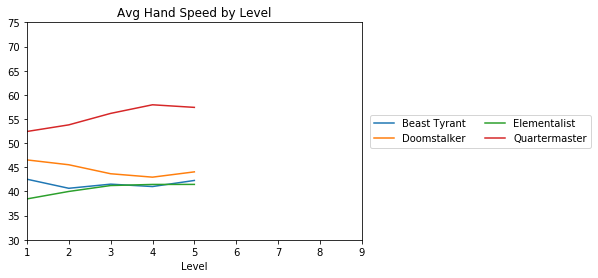

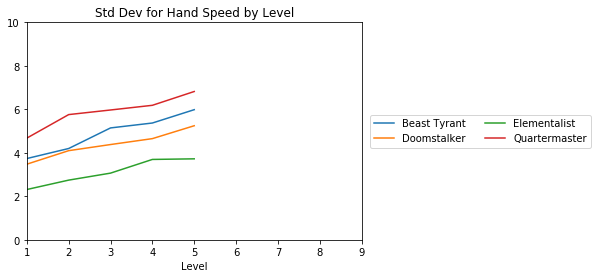

In [14]:
fig, ax = plt.subplots()

for key, grp in total_results_df.groupby(['Class']):
    ax = grp.plot(ax=ax,kind='line', x='Level', y='Average', label=key, title='Avg Hand Speed by Level')

plt.axis([1,9,30,75])
# plt.legend(loc='best', ncol = 2)
plt.legend(loc='center right', ncol = 2, bbox_to_anchor=(1.7, 0.5))
plt.show()


fig,ax = plt.subplots()

for key, grp in total_results_df.groupby(['Class']):
    ax = grp.plot(ax=ax, kind='line', x='Level', y='Std. Dev.', label=key, title='Std Dev for Hand Speed by Level')

plt.axis([1,9,0,10])
# plt.legend(loc='best', ncol = 2)
plt.legend(loc='center right', ncol = 2, bbox_to_anchor=(1.7, 0.5))
plt.show()

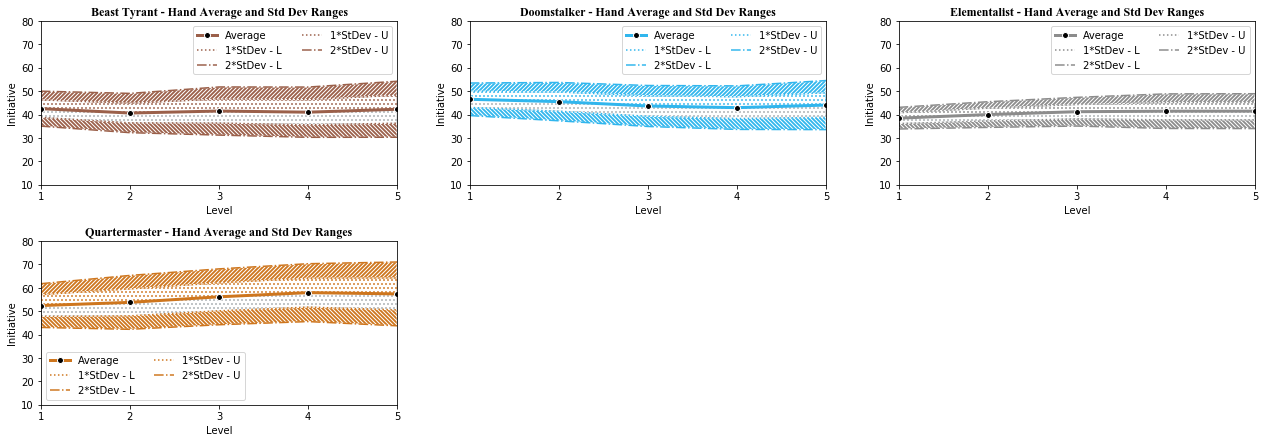

In [12]:
# Creating a figure to hold the plots
fig = plt.figure(figsize=(18,15))
i = 1

# Beginning a loop for each class in the results output.  This will be used to create the plots by class
for key, grp in total_results_df.groupby(['Class']):
    
    # X and Y variables to plot
    x = grp['Level']
    y1 = grp['Average']
    y2 = grp['U_1StdDev']
    y3 = grp['L_1StdDev']
    y4 = grp['U_2StdDev']
    y5 = grp['L_2StdDev']
    
    # Adding a subplot to the base figure
    ax = fig.add_subplot(5, 3, i)
    
    # Plotting the average
    ax = grp.plot(ax=ax, kind='line', x='Level', y='Average', label='Average', 
                  color=gen_classinfo[gen_classinfo['Class']==key]['Class Symbol Color'], linewidth=3, 
                  markevery=1, marker='o', markerfacecolor='black', markeredgecolor='white')
    
    # Plotting the lower bound of the standard deviation
    ax = grp.plot(ax=ax, kind='line', x='Level', y='L_1StdDev', label='1*StDev - L', 
                  color=gen_classinfo[gen_classinfo['Class']==key]['Class Symbol Color'],
                  linestyle=":")
    
    ax = grp.plot(ax=ax, kind='line', x='Level', y='L_2StdDev', label='2*StDev - L', 
              color=gen_classinfo[gen_classinfo['Class']==key]['Class Symbol Color'],
              linestyle="-.")
    
    # Plotting the upper bound of the standard deviation
    ax = grp.plot(ax=ax, kind='line', x='Level', y='U_1StdDev', label='1*StDev - U',  
                  color=gen_classinfo[gen_classinfo['Class']==key]['Class Symbol Color'], 
                  linestyle=":")

    ax = grp.plot(ax=ax, kind='line', x='Level', y='U_2StdDev', label='2*StDev - U',  
                  color=gen_classinfo[gen_classinfo['Class']==key]['Class Symbol Color'], 
                  linestyle="-.")
    
    # Titling the subplot
    ax.set_title(key + " - Hand Average and Std Dev Ranges", fontname="Times New Roman")
    
    # Setting the axis limits and labels
    ax.axis([1,5,10,80])
    ax.set_xlabel('Level')
    ax.set_ylabel('Initiative')
    ax.set_xticks(grp['Level'])
    
    # Creating the coloring/formatting for the space between the average and +- (2*Std. Deviation)
    # Between Average and Upper Bound 1
    ax.fill_between(x, y1, y2, where = (y2 > y1), facecolor='#FFFFFF', 
                    edgecolor=gen_classinfo[gen_classinfo['Class']==key]['Class Symbol Color'], hatch=3*".")
    
    ax.fill_between(x, y2, y4, where = (y4 > y2), edgecolor='#FFFFFF', 
                    facecolor=gen_classinfo[gen_classinfo['Class']==key]['Class Symbol Color'], hatch=3*"//")
    
    # Between Average and Lower Bound
    # #E8EAEB'
    ax.fill_between(x, y1, y3, where = (y3 < y1), facecolor='#FFFFFF', edgecolor='#A5ACAF', hatch=3*".")

    ax.fill_between(x, y3, y5, where = (y5 < y3), edgecolor='#FFFFFF', 
                    facecolor=gen_classinfo[gen_classinfo['Class']==key]['Class Symbol Color'], hatch=6*"\\")
    
    
    
    # Setting up the Legend
    ax.legend(ncol=2)
    
    i += 1

# Adjusting the plot spacing in the figure
plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=1, hspace=1)
plt.tight_layout()